# International Workshop on Spectroscopy and Chemometrics 2022
# Data Challenge Solution - Tabular Models

# Data Description

Notes and Objective:
The dataset has been divided (by the organizers) into two Excel sheets
- Training dataset: contains the value to predict (cow diet) and the spectra
- Test dataset: contains only the spectra
The test dataset contains 1,089 spectra.

**The aim of the analysis is to predict the cow diet for the samples in the test dataset.**

**Sample collection**
Data used in this study originated from Teagasc Moorepark Dairy Research Farm (Fermoy, Co. Cork, Ireland) between May and August in 2015, 2016, and 2017. A total of 120 Holstein- Friesian cows from different parities were involved in the experiment across the years, with a mean number of 36 samples per cow, and with some of the cows participating in the experiment in more than 1 yr. Each year, 54 cows were randomly assigned to different dietary treatments for the entire lactation period. 

The treatment diets included grass (GRS), which consisted of cows maintained outdoors on a perennial ryegrass sward only, clover (CLV), where cows were maintained outdoors on a perennial ryegrass white clover sward (with an annual average clover content of 20%) only, and TMR, where cows were maintained indoors and fed with a single nutritional mix containing grass silage, maize silage, and concentrates. Further information on the experimental design and dietary treatments have been described by O’Callaghan et al. (2016). The cows were milked twice daily (0730 and 1530 h), and a.m. and p.m. milk samples were collected once weekly from consecutive milkings and analysed by a Pro-Foss FT6000 (FOSS). A total of 4,364 milk spectra were stored, comprising 1,060 wavelengths in the region from 925 cm−1 and 5,010 cm−1. The wavelengths values were recorded as transmittance values.

O’Callaghan, T. F., D. Hennessy, S. McAuliffe, K. N. Kilcawley, M. O’Donovan, P. Dillon, R. P. Ross, and C. Stanton. 2016. Effect of pasture versus indoor feeding systems on raw milk composition and quality over an entire lactation. J. Dairy Sci. 99:9424–9440. https://doi.org/10.3168/jds.2016-10985.


# Run tabular experiments:

+ Useful recent ref: https://www.journalofdairyscience.org/article/S0022-0302(21)00909-7/fulltext
+ In that work LDA and LASSO work well.
+ check water regions: 172-205 536-728 748-end
+ use 3-fold cv for comparison of results of diff algos; also look at single train-test split
+ tuning models: grid search
+ compare results on fixed train_test split (eg avg RidgeCV and GBR models)?
+ voting windows to automatically find important regions of the time series
+ other ideas: for final submission, we could average the best models and submit the average (eg average/ensemble the tabular and the TS methods); it would be nice to look more into explanation methods for time series, eg saliency maps obtained with different methods such as LIME and Shapley

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os, sys
import time

#data
from sklearn.preprocessing import StandardScaler

#linear models
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
#from sklearn.cross_decomposition import PLSRegression

#linear models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.linear_model import RidgeClassifier, LassoClassifier, ElasticNetClassifier, RidgeClassifierCV, LassoClassifierCV, ElasticNetClassifierCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression
from sklearn.svm import LinearSVC

#from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#ensembles
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
#https://hub.packtpub.com/rotation-forest-classifier-ensemble-based-feature-extraction/
from rotation_forest import RotationTreeClassifier, RotationForestClassifier

#from lightgbm import LGBMRegressor
#from xgboost.sklearn import XGBRegressor

#knn
from sklearn.neighbors import KNeighborsClassifier

#neural networks
from sklearn.neural_network import MLPClassifier

#svm: try both linear kernel and rbf kernel
from sklearn.svm import SVC

#deep learning
#tbd: 

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest

#evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold


from patsy import dmatrices
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted
#from pandas_profiling import ProfileReport

#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import MiniRocket
#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.utils.data_processing import from_2d_array_to_nested, is_nested_dataframe

In [252]:
#training_df = pd.read_excel('data/vmdata.xlsx', 0, engine='openpyxl')
#test_df = pd.read_excel('data/vmdata.xlsx', 1, engine='openpyxl')
#print("Training shape: ", training_df.shape)
#print("Test shape: ", test_df.shape)

In [253]:
#training_df.to_csv("data/train.csv", index = False)
#test_df.to_csv("data/test.csv", index = False)

In [254]:
training_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [255]:
print("Training shape: ", training_df.shape)
print("Test shape: ", test_df.shape)

Training shape:  (3275, 1061)
Test shape:  (1089, 1060)


In [256]:
"Total cows: ",  training_df.shape[0] + test_df.shape[0]

('Total cows: ', 4364)

In [257]:
training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,GRS,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,GRS,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,GRS,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863
3,GRS,1.204441,1.193640,1.183685,1.174031,1.164706,1.155768,1.147259,1.139031,1.130472,...,0.972673,0.973021,0.973390,0.973784,0.974206,0.974654,0.975121,0.975456,0.975953,0.976483
4,GRS,1.280609,1.264384,1.250152,1.237041,1.224849,1.213294,1.202137,1.191109,1.179676,...,0.958123,0.958400,0.958773,0.959264,0.959864,0.960536,0.961223,0.961681,0.962278,0.962797


In [258]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Columns: 1061 entries, Diet to col1060
dtypes: float64(1060), object(1)
memory usage: 26.5+ MB


In [259]:
training_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,3275.0,1.224632,0.109307,0.200451,1.201450,1.233044,1.263995,1.489349
col2,3275.0,1.212087,0.107605,0.197335,1.190346,1.220362,1.249970,1.463645
col3,3275.0,1.200541,0.106066,0.194482,1.180232,1.208841,1.236811,1.440033
col4,3275.0,1.189475,0.104590,0.191707,1.170511,1.197907,1.224258,1.416911
col5,3275.0,1.178933,0.103169,0.189006,1.161068,1.187339,1.212192,1.393804
col6,3275.0,1.168909,0.101799,0.186321,1.152576,1.177197,1.200616,1.370367
col7,3275.0,1.159350,0.100490,0.183667,1.144497,1.167856,1.189460,1.346619
col8,3275.0,1.150042,0.099248,0.180993,1.136638,1.158518,1.178745,1.322929
col9,3275.0,1.140407,0.098046,0.178249,1.128281,1.148715,1.168039,1.299676
col10,3275.0,1.129354,0.096797,0.175389,1.118568,1.137601,1.155896,1.276790


In [260]:
training_df['Diet'].value_counts()

CLV    1120
GRS    1094
TMR    1061
Name: Diet, dtype: int64

In [261]:
#outlier spectra
#training_df[training_df['col1'] < 1]

In [262]:
#remove outlier spectra with col1 < 1
training_df = training_df[training_df['col1'] >= 1]

In [263]:
training_df['Diet'].value_counts()

CLV    1108
GRS    1082
TMR    1054
Name: Diet, dtype: int64

In [264]:
test_df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.317418,1.299994,1.284558,1.270085,1.256384,1.243233,1.230456,1.217821,1.204802,1.190368,...,0.937689,0.938134,0.938614,0.939119,0.939631,0.940134,0.940621,0.940953,0.941424,0.941899
1,1.316640,1.299685,1.284699,1.270432,1.256800,1.243672,1.230912,1.218294,1.205288,1.190875,...,0.919305,0.919648,0.920018,0.920458,0.920975,0.921541,0.922106,0.922466,0.922939,0.923350
2,1.209746,1.196516,1.184740,1.174105,1.164847,1.156824,1.149617,1.142574,1.134739,1.124788,...,0.970130,0.970361,0.970555,0.970754,0.971008,0.971354,0.971804,0.972164,0.972751,0.973371
3,1.336356,1.318198,1.301790,1.286056,1.271100,1.256870,1.243191,1.229715,1.215774,1.200255,...,0.922056,0.922449,0.922868,0.923344,0.923886,0.924473,0.925061,0.925436,0.925920,0.926315
4,1.332259,1.313666,1.297593,1.282746,1.268823,1.255356,1.241928,1.228219,1.213810,1.197925,...,0.918629,0.919234,0.919818,0.920360,0.920856,0.921318,0.921762,0.922058,0.922488,0.922912


In [265]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Columns: 1060 entries, col1 to col1060
dtypes: float64(1060)
memory usage: 8.8 MB


In [266]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,1089.0,1.225367,0.117075,0.202345,1.201685,1.233364,1.266169,1.424172
col2,1089.0,1.212738,0.115314,0.199096,1.190699,1.220993,1.252325,1.402551
col3,1089.0,1.201104,0.113723,0.196168,1.180659,1.209428,1.239401,1.382655
col4,1089.0,1.189947,0.112200,0.193352,1.170665,1.198623,1.226548,1.363035
col5,1089.0,1.179314,0.110734,0.190633,1.161789,1.188106,1.214937,1.343277
col6,1089.0,1.169200,0.109323,0.187762,1.153645,1.177837,1.203693,1.323126
col7,1089.0,1.159554,0.107975,0.184908,1.145893,1.168624,1.192598,1.302628
col8,1089.0,1.150162,0.106693,0.182064,1.137758,1.159528,1.181280,1.282055
col9,1089.0,1.140446,0.105446,0.179169,1.129728,1.150057,1.169677,1.261590
col10,1089.0,1.129314,0.104140,0.176169,1.119647,1.138768,1.157460,1.240946


In [267]:
#test_df[test_df['col1'] < 1]

In [268]:
#remove outlier spectra with col1 < 1
test_df = test_df[test_df['col1'] >= 1]

The data is arranged such that each row belongs to a particular cow. 

In [269]:
#training_df.describe().T

In [270]:
#test_df.describe().T

In [271]:
#training_df.isnull().sum()

In [272]:
#test_df.isnull().sum()

# Targets: GRS, CLV, TMR

In [273]:
pd.set_option('display.max_rows', training_df.shape[0]+1)

In [274]:
target_columns = ["CLV", "GRS", "TMR"]
features = [col for col in training_df.columns if col not in 'Diet']
#print(features)
training_df[features].head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,1.169188,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,1.108886,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,1.217361,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863


In [275]:
#shuffle the rows to deal with ordering by given target
training_df = training_df.sample(frac=1, random_state=0)

#X = training_df.iloc[:,1:]
#Y = training_df["Diet"]
X = training_df[features]
y = training_df['Diet']

training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
1341,CLV,1.262803,1.248776,1.235850,1.223375,1.211239,1.199327,1.187591,1.175970,1.164142,...,0.905738,0.905706,0.905739,0.905933,0.906323,0.906881,0.907533,0.908016,0.908626,0.909125
2455,TMR,1.312190,1.295569,1.280012,1.264803,1.250052,1.235895,1.222456,1.209677,1.197046,...,0.877743,0.878292,0.878873,0.879410,0.879856,0.880221,0.880566,0.880854,0.881346,0.881967
2413,GRS,1.199044,1.188237,1.178328,1.168968,1.160195,1.151940,1.144051,1.136218,1.127804,...,0.914353,0.914588,0.914990,0.915584,0.916338,0.917167,0.917954,0.918445,0.918932,0.919205
2240,GRS,1.199403,1.188016,1.177516,1.167560,1.158180,1.149308,1.140835,1.132538,1.123869,...,0.938855,0.939272,0.939944,0.940794,0.941708,0.942563,0.943263,0.943645,0.943973,0.944113
305,GRS,1.266574,1.252683,1.240152,1.228308,1.217053,1.206215,1.195646,1.185168,1.174354,...,0.944685,0.945091,0.945490,0.945860,0.946198,0.946521,0.946864,0.947136,0.947602,0.948168


In [276]:
#X = training_df[features]
#y = training_df['Diet']
ridge = RidgeClassifier().fit(X, y)
y_pred = ridge.predict(X)
# Print the estimated linear regression coefficients.
#print("Features: \n", features)
#print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])


Intercept: 
 [  3.13398848 -28.67027295  24.53628448]

Features and coeficients: [('col1', array([ 0.32605869,  0.21834103,  0.17722726, ..., -0.26846248,
       -0.27457   , -0.27758055])), ('col2', array([ 0.89340788,  0.90858759,  0.9347545 , ..., -0.07223615,
       -0.0660347 , -0.060797  ])), ('col3', array([-1.21946657, -1.12692862, -1.11198176, ...,  0.34069863,
        0.3406047 ,  0.33837755]))]


In [277]:
#y.unique()

In [278]:
#unique_labels(y)

In [279]:
# Predicted scores for each example. 
def predict_eval(clf, y, y_pred):

    actual_vs_predicted = pd.concat([y, pd.DataFrame(y_pred, columns=['Predicted'], index=y.index)], axis=1)
    actual_vs_predicted.head()
    print(f'Accuracy: {accuracy_score(y, y_pred)}')

    cm = confusion_matrix(y, y_pred, labels=unique_labels(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=unique_labels(y))
    disp.plot()
    plt.grid(False)
    plt.show()

Accuracy: 0.5668927250308261


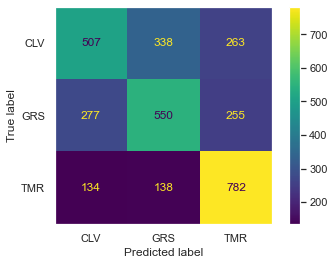

In [280]:
predict_eval(ridge, y, y_pred)

In [281]:
#This function is used repeatedly to compute all metrics
def printMetrics(y, y_pred):
    #classification evaluation measures
    print('\n==============================================================================')
    #print("Accuracy: ", metrics.accuracy_score(y, y_pred))
    #print("Confusion matrix: \n", metrics.confusion_matrix(y, y_pred))
    print("Classification report:\n ", metrics.classification_report(y, y_pred))

In [282]:
#printMetrics(y, ridge_predictions)

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


Accuracy: 0.5760534429599178


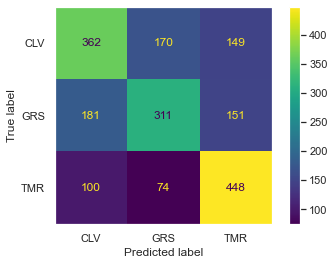


Intercept: 
 [ -1.17224596 -30.6760794   30.84832536]

Features and coeficients: [('col1', array([ 0.24947647,  0.17487266,  0.14099018, ..., -0.28276296,
       -0.28081812, -0.27420264])), ('col2', array([0.64661004, 0.66260573, 0.67634284, ..., 0.00955889, 0.01746   ,
       0.02120377])), ('col3', array([-0.89608651, -0.83747839, -0.81733302, ...,  0.27320407,
        0.26335812,  0.25299887]))]


In [284]:
# Train on the training sample and test on the test sample.
ridge = RidgeClassifier().fit(X_train, y_train)
y_pred = ridge.predict(X_train)
predict_eval(ridge, y_train, y_pred)

# Print the weights learned for each feature.
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])

In [285]:
#print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, y_pred)


Classification report:
                precision    recall  f1-score   support

         CLV       0.56      0.53      0.55       681
         GRS       0.56      0.48      0.52       643
         TMR       0.60      0.72      0.65       622

    accuracy                           0.58      1946
   macro avg       0.57      0.58      0.57      1946
weighted avg       0.57      0.58      0.57      1946



Accuracy: 0.46687211093990755


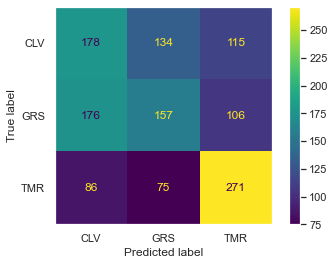


Classification report:
                precision    recall  f1-score   support

         CLV       0.40      0.42      0.41       427
         GRS       0.43      0.36      0.39       439
         TMR       0.55      0.63      0.59       432

    accuracy                           0.47      1298
   macro avg       0.46      0.47      0.46      1298
weighted avg       0.46      0.47      0.46      1298



In [286]:
# Predicted price on test set
y_pred = ridge.predict(X_test)
predict_eval(ridge, y_test, y_pred)
printMetrics(y_test, y_pred)
#print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head().sort_values('kappa_casein'))

In [287]:
def exp_single_clf(clf, X_train, X_test, y_train, y_test):    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [288]:
error_measures = ['accuracy']
scores = cross_validate(RidgeClassifier(), X, y, scoring=error_measures, cv=3)
scores

{'fit_time': array([0.13709116, 0.16657996, 0.12453389]),
 'score_time': array([0.01365089, 0.01523614, 0.01501393]),
 'test_accuracy': array([0.48983364, 0.5013876 , 0.48843663])}

In [289]:
def printMetricsClassifCV(clf, X, y, metrics = ['acc']):
    #run cross-validation to compute the rmse for different folds, using different regression algorithms
    print('\n==============================================================================')
    scores = cross_validate(clf, X, y, scoring=metrics, cv=4)
    scores
    #print("MAE: ", -scores['test_neg_mean_absolute_error'])
    print("Acc: ", scores['test_accuracy'])

In [180]:
list_clf = [
            #RidgeClassifier(), 
            #RidgeClassifierCV(), 
            #RidgeClassifierCV(normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-4, 4, 10), normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-6, 6, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-10, 10, 10), normalize=True), 
            #LogisticRegression(penalty='l2'), LogisticRegression(penalty='l1'), 
            #GaussianNB(), 
            LinearDiscriminantAnalysis(), 
            #QuadraticDiscriminantAnalysis(), LinearSVC(),
            #RandomForestClassifier(n_estimators=100), 
            #GradientBoostingClassifier(n_estimators=100),
            #ExtraTreesClassifier(n_estimators=100)
            #RotationForestClassifier(n_estimators=25, n_features_per_subset=3, rotation_algo='randomized'),
            #KNeighborsClassifier(n_neighbors=3),  
            #MLPClassifier(alpha=1, max_iter=1000), 
            #SVC(kernel="linear", C=0.025), 
            #SVC(gamma=2, C=1)
            ]
            
            
def algoCV(list_clf, X, y, folds = 3, error_measures = ['accuracy']):
    
    algos_df = pd.DataFrame({"algo":[], "acc": []})

    for algo in list_clf:
        print(algo)
        scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        
        algos_df = algos_df.append({"algo":str(algo), "acc": np.mean(acc)}, ignore_index=True)
             
        print("acc: ", acc)
        print("accCV: ", np.mean(acc))
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        print("time fit+score:", fit_time + score_time)
        print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))
    algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    
if __name__ == "__main__":
    
    algoCV(list_clf, X, y)
    

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)
acc:  [0.75600739 0.73820537 0.73635523]
accCV:  0.7435226619199152
time fit+score: 1.269044319788615


RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                  normalize=True)
acc:  [0.76617375 0.76595745 0.7493062 ]
accCV:  0.760479132361298
time fit+score: 1.1212038199106853


LinearDiscriminantAnalysis()
acc:  [0.74861368 0.74190564 0.75208141]
accCV:  0.7475335758006866
time fit+score: 1.2747716903686523


                                                algo       acc
1  RidgeClassifierCV(alphas=array([1.00000000e-05...  0.760479
2                       LinearDiscriminantAnalys

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()


In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


Accuracy: 0.7719568567026194


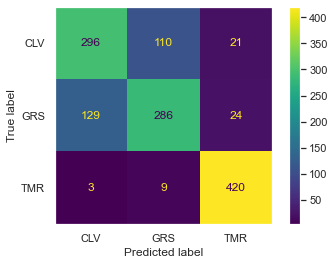

In [182]:
#Without feature selection
clf = Pipeline([
  #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7372881355932204


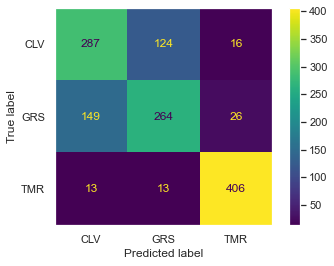

In [183]:
#Without feature selection
clf = Pipeline([
  #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7719568567026194


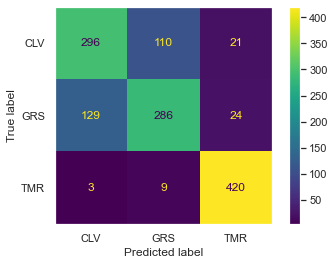

col1 [12.31144564 -8.07238117 -4.23906447]
col2 [-5.60578064 11.69962293 -6.09384229]
col3 [-9.98332534 13.00672642 -3.02340108]
col4 [-2.69742595  2.95022275 -0.2527968 ]
col5 [ 8.10431386 -8.34018146  0.23586759]
col6 [ 14.04802176 -12.54033473  -1.50768702]
col7 [10.59347865 -7.09513985 -3.4983388 ]
col8 [-0.90371311  4.06636483 -3.16265173]
col9 [-14.01713736  13.15782483   0.85931252]
col10 [-21.02476343  13.51311078   7.51165265]
col11 [-17.96267572   4.24383837  13.71883735]
col12 [-7.41387961 -8.96774168 16.38162128]
col13 [  3.4142175  -17.96157836  14.54736086]
col14 [  7.91042006 -18.04174162  10.13132156]
col15 [  4.72546672 -11.38704039   6.66157368]
col16 [-1.5031915 -5.2503626  6.7535541]
col17 [-4.20966845 -5.90895773 10.11862618]
col18 [ -0.50636098 -13.37766356  13.88402454]
col19 [  6.62436765 -21.45686672  14.83249908]
col20 [ 11.03062765 -22.4620534   11.43142575]
col21 [  8.24196433 -12.74233989   4.50037556]
col22 [-1.17419516  4.19801956 -3.0238244 ]
col23 [-12.

col696 [ 9.1028411  -4.20507979 -4.89776131]
col697 [ 3.56984049 -2.29317558 -1.27666491]
col698 [-8.03470598  4.04118582  3.99352016]
col699 [-5.47421388  3.06598285  2.40823103]
col700 [ 6.35535291 -3.72410531 -2.6312476 ]
col701 [ 8.01964012 -5.01363021 -3.00600991]
col702 [-2.240851   1.2872806  0.9535704]
col703 [-8.81591629  5.92766557  2.88825072]
col704 [-2.99299302  2.20805588  0.78493713]
col705 [ 6.52670839 -5.03516931 -1.49153908]
col706 [ 7.17588191 -5.68109043 -1.49479148]
col707 [-1.24859414  1.85027174 -0.60167761]
col708 [-8.19691239  7.12915924  1.06775315]
col709 [-4.95300741  2.12411943  2.82888798]
col710 [ 6.039163   -6.40434674  0.36518374]
col711 [ 9.30549006 -5.55009958 -3.75539048]
col712 [-2.80977758  4.29944397 -1.48966639]
col713 [-10.66214765   7.58727454   3.07487311]
col714 [-1.70081791 -0.70873035  2.40954826]
col715 [ 8.35934548 -8.02967691 -0.32966856]
col716 [ 8.51584175 -7.04250269 -1.47333906]
col717 [ 2.05175626 -0.65617134 -1.39558492]
col718 [-4

In [184]:
clf = RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(ridge, y_test, y_pred)

for idx in range(0, len(features)):
    #if selector.get_support()[idx]:
    print(features[idx], clf.coef_[:,idx])

Accuracy: 0.7827426810477658


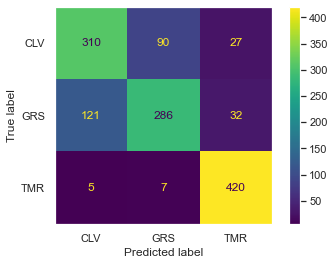


Classification report:
                precision    recall  f1-score   support

         CLV       0.71      0.73      0.72       427
         GRS       0.75      0.65      0.70       439
         TMR       0.88      0.97      0.92       432

    accuracy                           0.78      1298
   macro avg       0.78      0.78      0.78      1298
weighted avg       0.78      0.78      0.78      1298



In [185]:
#Testing feature selection
#th = "median"
th = "mean"

clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = th)),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)

In [186]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = "median")),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True),
                                 threshold='median')),
                ('classification',
                 RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                   normalize=True))])
acc:  [0.77449168 0.78168363 0.75670675]
accCV:  0.7709606871162288
time fit+score: 1.6485954125722249




Accuracy: 0.7958397534668721


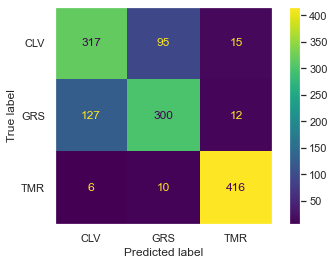


Classification report:
                precision    recall  f1-score   support

         CLV       0.70      0.74      0.72       427
         GRS       0.74      0.68      0.71       439
         TMR       0.94      0.96      0.95       432

    accuracy                           0.80      1298
   macro avg       0.79      0.80      0.79      1298
weighted avg       0.79      0.80      0.79      1298



In [187]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = "mean")),
  ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)

In [188]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', LinearDiscriminantAnalysis())
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('classification', LinearDiscriminantAnalysis())])
acc:  [0.78465804 0.78075856 0.77058279]
accCV:  0.7786664637555765
time fit+score: 1.5268725554148355




In [189]:
selector = SelectFromModel(estimator=RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)).fit(X_train, y_train)
#selector.estimator_.coef_
selector.threshold_
selector.get_support().sum()
#selector.get_support()

312

In [190]:
selector.estimator_.coef_

array([[ 12.31144564,  -5.60578064,  -9.98332534, ..., -11.12499045,
        -15.53104525, -16.16260089],
       [ -8.07238117,  11.69962293,  13.00672642, ...,   8.123713  ,
         12.66065365,  15.77988069],
       [ -4.23906447,  -6.09384229,  -3.02340108, ...,   3.00127745,
          2.8703916 ,   0.38272021]])

In [191]:
for idx in range(0, len(selector.get_support())):
    #if selector.get_support()[idx]:
    print(features[idx], selector.estimator_.coef_[:,idx])

col1 [12.31144564 -8.07238117 -4.23906447]
col2 [-5.60578064 11.69962293 -6.09384229]
col3 [-9.98332534 13.00672642 -3.02340108]
col4 [-2.69742595  2.95022275 -0.2527968 ]
col5 [ 8.10431386 -8.34018146  0.23586759]
col6 [ 14.04802176 -12.54033473  -1.50768702]
col7 [10.59347865 -7.09513985 -3.4983388 ]
col8 [-0.90371311  4.06636483 -3.16265173]
col9 [-14.01713736  13.15782483   0.85931252]
col10 [-21.02476343  13.51311078   7.51165265]
col11 [-17.96267572   4.24383837  13.71883735]
col12 [-7.41387961 -8.96774168 16.38162128]
col13 [  3.4142175  -17.96157836  14.54736086]
col14 [  7.91042006 -18.04174162  10.13132156]
col15 [  4.72546672 -11.38704039   6.66157368]
col16 [-1.5031915 -5.2503626  6.7535541]
col17 [-4.20966845 -5.90895773 10.11862618]
col18 [ -0.50636098 -13.37766356  13.88402454]
col19 [  6.62436765 -21.45686672  14.83249908]
col20 [ 11.03062765 -22.4620534   11.43142575]
col21 [  8.24196433 -12.74233989   4.50037556]
col22 [-1.17419516  4.19801956 -3.0238244 ]
col23 [-12.

col575 [-1.71255699  0.61578047  1.09677652]
col576 [-1.96266329 -0.71491795  2.67758124]
col577 [ 1.12159288 -0.04793159 -1.07366129]
col578 [ 2.0146498   1.35838376 -3.37303356]
col579 [-0.02641682  0.08465008 -0.05823326]
col580 [-1.24409359 -2.57252639  3.81661997]
col581 [-0.81702816 -0.54160941  1.35863757]
col582 [ 0.79143227  3.0472151  -3.83864737]
col583 [ 1.50467858  0.52336625 -2.02804483]
col584 [-0.53449773 -2.63599073  3.17048846]
col585 [-1.18903238 -0.11871302  1.30774539]
col586 [ 0.57765281  1.65009847 -2.22775128]
col587 [ 0.76716144 -0.97272843  0.20556699]
col588 [-1.10361284  0.53707495  0.5665379 ]
col589 [ 1.07043575 -0.59066087 -0.47977488]
col590 [-1.01318068  0.6935473   0.31963338]
col591 [ 0.63057091 -0.576684   -0.05388691]
col592 [-0.40252959  0.45786013 -0.05533054]
col593 [ 0.35845519 -0.47187227  0.11341708]
col594 [-0.25390524  0.36510405 -0.11119882]
col595 [ 0.21196838 -0.31857287  0.10660449]
col596 [-0.94053787  0.78635582  0.15418205]
col597 [ 2

In [192]:
#import numpy.ma as ma
#features_selected = ma.masked_where(selector.get_support(), features)
for idx in range(0, len(selector.get_support())):
    if selector.get_support()[idx]:
        print(features[idx])

col44
col45
col46
col47
col50
col51
col52
col53
col54
col55
col56
col57
col72
col73
col74
col76
col77
col78
col79
col80
col81
col82
col83
col84
col85
col86
col87
col88
col90
col91
col92
col93
col94
col95
col96
col97
col98
col99
col100
col101
col102
col104
col105
col106
col107
col108
col109
col110
col111
col112
col113
col115
col116
col119
col120
col121
col123
col124
col125
col126
col127
col128
col129
col130
col131
col132
col133
col134
col135
col136
col141
col142
col143
col144
col153
col154
col208
col219
col220
col221
col222
col227
col228
col229
col230
col231
col232
col233
col234
col235
col236
col237
col238
col239
col240
col241
col242
col243
col244
col245
col248
col249
col250
col253
col254
col255
col256
col257
col261
col262
col263
col264
col265
col271
col272
col273
col274
col275
col276
col279
col280
col281
col282
col283
col284
col285
col286
col287
col288
col289
col290
col291
col292
col293
col294
col295
col296
col297
col298
col299
col300
col301
col308
col309
col310
col311
col312
col313
co

In [193]:
for idx in range(0, len(selector.get_support())):
    if selector.get_support()[idx]:
        print(features[idx], selector.estimator_.coef_[:,idx])

col44 [-18.14038427  46.43425098 -28.29386671]
col45 [-18.1276669   61.23271929 -43.10505239]
col46 [-18.04197323  62.68677025 -44.64479701]
col47 [-17.68150463  47.30572142 -29.62421679]
col50 [ -3.01063855 -43.82477411  46.83541266]
col51 [  8.5688952  -57.67733198  49.10843678]
col52 [ 22.24672177 -52.61853357  30.3718118 ]
col53 [ 35.1834579  -30.17320138  -5.01025652]
col54 [ 42.62787185   2.30475857 -44.93263042]
col55 [ 39.16135857  32.45077901 -71.61213758]
col56 [ 24.14829422  46.68279585 -70.83109007]
col57 [  5.57311987  40.82955518 -46.40267505]
col72 [ 41.35430959   3.27261654 -44.62692613]
col73 [ 57.63519549  -8.45066193 -49.18453355]
col74 [ 47.85294709 -19.75587394 -28.09707315]
col76 [-47.72283434  -1.13379042  48.85662475]
col77 [-77.14840055  19.76114351  57.38725705]
col78 [-67.97111447  32.48564013  35.48547435]
col79 [-30.34450459  32.89612391  -2.55161933]
col80 [ 14.83970398  23.84496948 -38.68467346]
col81 [ 50.70099291   9.70723243 -60.40822533]
col82 [ 68.89

col896 [-32.48438254  20.98896819  11.49541435]
col897 [-37.44386903  23.77996337  13.66390567]
col898 [-30.90803732  17.93420323  12.97383409]
col906 [-34.53416941  28.59654038   5.93762903]
col907 [-35.80151741  28.6782828    7.1232346 ]
col908 [-29.29247243  23.02991943   6.262553  ]


# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.

In [194]:
class IntervalSelector(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, start = 0, end = 10, return_timeseries = True):        
        self.start = start
        self.end = end
        self.return_timeseries = return_timeseries
            
            
    def fit(self, X, y = None):        
        return self    
    
    def transform(self, X, y = None):             
        if self.return_timeseries:
            return from_2d_array_to_nested(X.iloc[:,self.start:self.end])
        else:
            return X.iloc[:,self.start:self.end]

----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.714175654853621


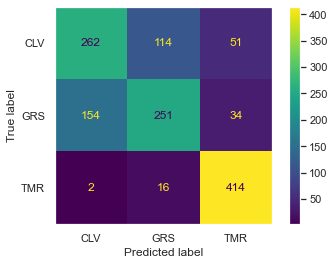

----------------------
Interval: 206 - 535
----------------------
Accuracy: 0.734206471494607


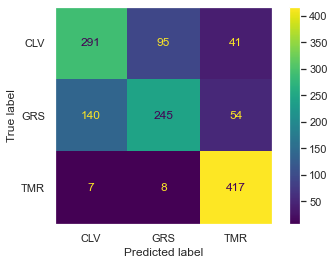

----------------------
Interval: 729 - 747
----------------------
Accuracy: 0.3320493066255778


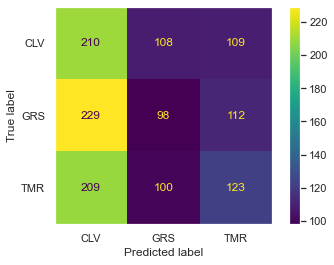

In [195]:
#Water region removal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,535),(729,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, y_test, y_pred)

Accuracy: 0.7904468412942989


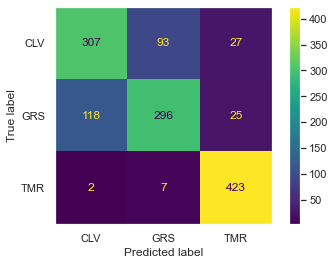

In [196]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]

clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True, class_weight='balanced'))
    ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7950693374422187


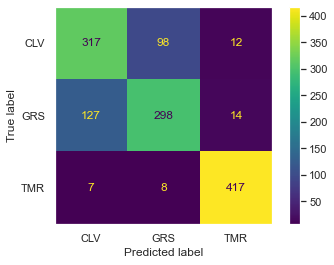

In [197]:
clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

In [198]:

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
       ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])

algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('classification',
                 RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                   normalize=True))])
acc:  [0.78465804 0.77983349 0.75393154]
accCV:  0.7728076910142875
time fit+score: 0.5404772758483887




In [199]:
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])

algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('classification', LinearDiscriminantAnalysis())])
acc:  [0.77818854 0.79000925 0.75763182]
accCV:  0.7752765376072337
time fit+score: 0.6178870995839437




----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.687211093990755


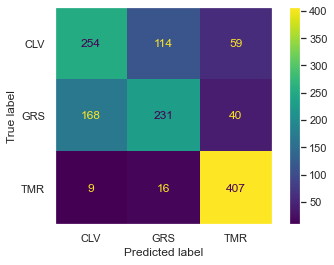

----------------------
Interval: 206 - 535
----------------------
Accuracy: 0.714175654853621


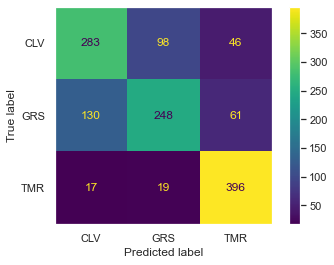

----------------------
Interval: 729 - 747
----------------------
Accuracy: 0.33975346687211094


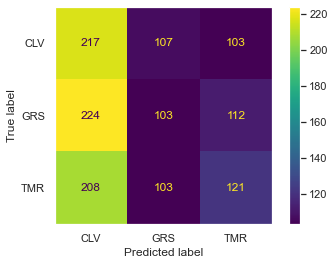

In [200]:
#Water region removal + feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,535),(729,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, y_test, y_pred)

Accuracy: 0.7835130970724191


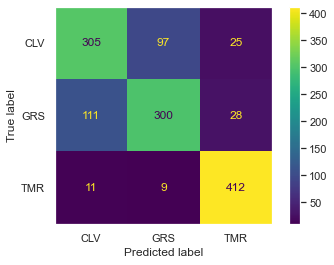

In [201]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7835130970724191


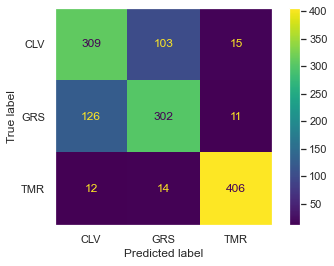

In [202]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.
+Best result so far: original data + feature selection (SelectFromModel()) + Ridge or LDA

In [212]:
# Try some noise removal before feature selection and learning
# Voting windows to do automatic water region removal
# Ideas to test: contiguous windows of fixed size, contiguous windows of random size, non-contiguous windows (essentially random feature subset selection of varying size)
def rankedWindows(X, y, runs, windowSize, classifier):

    results = {}
    
    if len(X.columns) % windowSize == 0:
        numberOfWindows = len(X.columns) // windowSize
    else:
        numberOfWindows = (len(X.columns) // windowSize) + 1
    
    print(numberOfWindows)
    
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.4, random_state = 0)
        
    for k in range(1, runs+1):

        #print(f"Run {k}")

        validationScores = []
        
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, test_size=0.4)

        for n in range(0, numberOfWindows):               
            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            if windowEnd > len(X.columns): 
                windowEnd = len(X.columns)          
            #print("windowStart:", windowStart)
            #print("windowEnd:", windowEnd)
            
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if (classifier == "MiniRocket"):
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)

                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                clf.fit(xTrainTransform, yTrainSplit)
                xValidateTransform = minirocket.transform(xValidateWindowSeries)
                y_pred = clf.predict(xValidateTransform)
                score = accuracy_score(y_pred, yValidate)
            
            
            elif (classifier == "RidgeClassifierCV"):
                clf = RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)
                clf.fit(xTrainWindow, yTrainSplit)
                y_pred = clf.predict(xValidateWindow)
                score = accuracy_score(y_pred, yValidate)
                
            validationScores.append(score)
            #print(validationScores)
            #print(windowStart, windowEnd)
            #print(score)
            
    
        for n in range(0, numberOfWindows):
            if n in results:
                results[n] += validationScores[n]
            else:
                results[n] = validationScores[n]
            #print(results)
             
        #print(results)       
                   
    #print(validationScores)
    for n in range(0, numberOfWindows):
        results[n] = results[n] / runs
    #print(results)
    
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key*windowSize
        newKeyEnd = newKeyStart + windowSize
        if newKeyEnd > len(X.columns): 
                newKeyEnd = len(X.columns) 
        updatedKeyResults[f"{newKeyStart}:{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [213]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 50, classifier = "RidgeClassifierCV")

22


In [214]:
ridge_windows

[('100:150', 0.6377406931964057),
 ('0:50', 0.606418485237484),
 ('500:550', 0.5666238767650834),
 ('50:100', 0.5571245186136072),
 ('450:500', 0.5440308087291399),
 ('200:250', 0.48677792041078305),
 ('250:300', 0.43234916559691916),
 ('150:200', 0.43029525032092425),
 ('300:350', 0.4110397946084724),
 ('350:400', 0.40333761232349163),
 ('400:450', 0.3974326059050064),
 ('900:950', 0.39178433889602055),
 ('850:900', 0.38818998716302955),
 ('800:850', 0.3797175866495507),
 ('750:800', 0.37098844672657255),
 ('1050:1060', 0.3676508344030809),
 ('700:750', 0.36636713735558407),
 ('1000:1050', 0.3640564826700899),
 ('550:600', 0.3637997432605905),
 ('950:1000', 0.358408215661104),
 ('650:700', 0.34069319640564827),
 ('600:650', 0.3406931964056482)]

In [215]:
#np.r_[0:50]

In [216]:
def evalWindows(ridge_windows, idx):
#idx = 22

    #print("idx: ", idx)
    subset_columns = np.array([])

    for w in ridge_windows[:idx]:
        #print(w[0])
        start = int(w[0].split(':')[0])
        end = int(w[0].split(':')[1])
        #if end > len(X.columns): 
        #    end = len(X.columns)
        #print(np.r_[start+1:end+1])
        #print(X_train.iloc[:, np.r_[start:end]].columns)
        #print(X_train.iloc[:, np.r_[start:end]].columns.to_list())
        #subset_columns = subset_columns.union(X_train.iloc[:, np.r_[start:end]].columns)
        subset_columns = np.concatenate((subset_columns, np.array(np.r_[start+1:end+1])), axis=None)
    
    #print(subset_columns)
    #print(np.sort(subset_columns))

    subset_columns = np.sort(subset_columns)

    #print(["col" + str(int(item)) for item in subset_columns])
    subset_index = pd.Index(["col" + str(int(item)) for item in subset_columns])
    #print(subset_index)
    return subset_index 
    

In [234]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")
algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    subset_index = evalWindows(ridge_windows, idx)

    X_train_auto_windows = X_train[subset_index]
    X_test_auto_windows = X_test[subset_index]

    clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        ])
    clf.fit(X_train_auto_windows, y_train)
    y_pred = clf.predict(X_test_auto_windows)
    #predict_eval(clf, y_test, y_pred)
    algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
print(algos_df.sort_values('acc', ascending=False))
    

12
   window_idx       acc
6           7  0.791217
4           5  0.787365
7           8  0.785054
5           6  0.784284
10         11  0.783513
11         12  0.782743
9          10  0.777350
8           9  0.775039
2           3  0.723421
3           4  0.723421
1           2  0.692604
0           1  0.643297


In [244]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    subset_index = evalWindows(ridge_windows, idx)

    X_train_auto_windows = X_train[subset_index]
    X_test_auto_windows = X_test[subset_index]

    clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
        #('feature_selection', SelectKBest(k = 50)),    
        ('classification', LinearDiscriminantAnalysis())
        ])
    clf.fit(X_train_auto_windows, y_train)
    y_pred = clf.predict(X_test_auto_windows)
    #predict_eval(clf, y_test, y_pred)
    algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
print(algos_df.sort_values('acc', ascending=False))
    

12
   window_idx       acc
9          10  0.805085
8           9  0.801233
10         11  0.798921
11         12  0.795840
4           5  0.786595
7           8  0.786595
6           7  0.783513
5           6  0.782743
2           3  0.731125
3           4  0.721880
1           2  0.716487
0           1  0.645609


In [235]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 50, classifier = "RidgeClassifierCV")

algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    
    subset_index = evalWindows(ridge_windows, idx)
     
    #X_train_auto_windows = X_train[subset_index]
    #X_test_auto_windows = X_test[subset_index]
    
    clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
        ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
      #('classification', LinearDiscriminantAnalysis())
    ])

    algo = clf
    folds = 3
    #print(algo)

    scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
    #scores
    acc = scores['test_accuracy']
    fit_time = np.mean(scores['fit_time'])
    score_time = np.mean(scores['score_time'])
    #print("acc: ", acc)
    #print("accCV: ", np.mean(acc))
    algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
    #print("fit_time: ", fit_time)
    #print("score_time: ", score_time)
    #print("time fit+score:", fit_time + score_time)
    #print("\n")
    
print(algos_df.sort_values('acc', ascending=False))
#algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    

22
   window_idx       acc
20         21  0.778359
21         22  0.777434
16         17  0.777124
19         20  0.776507
13         14  0.776201
10         11  0.775585
15         16  0.774968
14         15  0.774659
18         19  0.774659
17         18  0.774350
12         13  0.773425
11         12  0.772808
9          10  0.772504
8           9  0.762327
6           7  0.754933
7           8  0.753699
5           6  0.713317
4           5  0.709311
3           4  0.707766
2           3  0.696052
1           2  0.661828
0           1  0.625766


In [218]:
for wlength in range(10, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])
    
    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
        subset_index = evalWindows(ridge_windows, idx)

        X_train_auto_windows = X_train[subset_index]
        X_test_auto_windows = X_test[subset_index]

        clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        ])
        clf.fit(X_train_auto_windows, y_train)
        y_pred = clf.predict(X_test_auto_windows)
        #predict_eval(clf, y_test, y_pred)
        algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  10
106
[('130:140', 0.5478818998716304), ('0:10', 0.54403080872914), ('10:20', 0.5250320924261874), ('140:150', 0.5152759948652118), ('120:130', 0.500385109114249), ('490:500', 0.4806161745827985), ('100:110', 0.4664955070603337), ('70:80', 0.45879332477535295), ('80:90', 0.4510911424903723), ('520:530', 0.4369704749679076)]
    window_idx       acc
55          56  0.796610
64          65  0.796610
58          59  0.795840
71          72  0.795069
72          73  0.794299
56          57  0.794299
57          58  0.794299
65          66  0.792758
54          55  0.792758
73          74  0.792758
74          75  0.792758
62          63  0.791988
61          62  0.791988
69          70  0.791217
70          71  0.791217
53          54  0.791217
63          64  0.789676
67          68  0.789676
60          61  0.788136
68          69  0.787365
48          49  0.787365
50          51  0.787365
59          60  0.787365
51          52  0.787365
49          50  0.786595
92       

[('70:140', 0.6349165596919126), ('0:70', 0.6182284980744543), ('490:560', 0.5848523748395379), ('140:210', 0.5388960205391528), ('420:490', 0.5016688061617458), ('210:280', 0.4590500641848524), ('280:350', 0.4503209242618742), ('350:420', 0.3943517329910141), ('840:910', 0.386392811296534), ('910:980', 0.379204107830552)]
   window_idx       acc
8           9  0.791217
7           8  0.786595
9          10  0.784284
10         11  0.784284
14         15  0.783513
15         16  0.782743
13         14  0.779661
11         12  0.778120
12         13  0.775809
6           7  0.773498
4           5  0.722650
3           4  0.721109
5           6  0.720339
2           3  0.714946
1           2  0.685670
0           1  0.621726
window size:  80
14
[('80:160', 0.6590500641848525), ('0:80', 0.6364569961489088), ('480:560', 0.5817715019255456), ('160:240', 0.5080872913992297), ('240:320', 0.4729139922978177), ('400:480', 0.43517329910141206), ('320:400', 0.4028241335044929), ('880:960', 0.3884

In [245]:
for wlength in range(10, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])
    
    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
        subset_index = evalWindows(ridge_windows, idx)

        X_train_auto_windows = X_train[subset_index]
        X_test_auto_windows = X_test[subset_index]

        clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', LinearDiscriminantAnalysis())
        ])
        clf.fit(X_train_auto_windows, y_train)
        y_pred = clf.predict(X_test_auto_windows)
        #predict_eval(clf, y_test, y_pred)
        algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  10
106
[('0:10', 0.5637997432605906), ('130:140', 0.5450577663671374), ('10:20', 0.5306803594351732), ('140:150', 0.5093709884467266), ('120:130', 0.49576379974326057), ('490:500', 0.4813863928112966), ('100:110', 0.46418485237483953), ('70:80', 0.451604621309371), ('500:510', 0.4431322207958922), ('80:90', 0.4369704749679076)]
    window_idx       acc
73          74  0.804314
82          83  0.801233
81          82  0.801233
84          85  0.801233
74          75  0.801233
83          84  0.800462
99         100  0.800462
98          99  0.800462
89          90  0.800462
72          73  0.799692
97          98  0.799692
80          81  0.798921
94          95  0.798921
95          96  0.798921
96          97  0.798921
92          93  0.798151
91          92  0.798151
90          91  0.798151
78          79  0.798151
87          88  0.797381
101        102  0.797381
88          89  0.797381
85          86  0.796610
103        104  0.796610
48          49  0.795840
105   

[('70:140', 0.641591784338896), ('0:70', 0.6207958921694481), ('490:560', 0.5910141206675225), ('140:210', 0.5432605905006418), ('420:490', 0.5021822849807445), ('280:350', 0.4600770218228498), ('210:280', 0.4477535301668807), ('350:420', 0.4012836970474968), ('840:910', 0.3925545571245186), ('910:980', 0.37458279845956355)]
   window_idx       acc
13         14  0.801233
14         15  0.800462
12         13  0.798151
11         12  0.795840
15         16  0.795840
9          10  0.787365
10         11  0.786595
8           9  0.785054
7           8  0.781202
6           7  0.779661
5           6  0.777350
2           3  0.738059
3           4  0.735747
4           5  0.719569
1           2  0.697227
0           1  0.625578
window size:  80
14
[('80:160', 0.6521181001283697), ('0:80', 0.625160462130937), ('480:560', 0.5738125802310655), ('160:240', 0.5014120667522464), ('240:320', 0.47317073170731705), ('400:480', 0.4441591784338896), ('320:400', 0.39948652118100125), ('880:960', 0.37

In [222]:
for wlength in range(10, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])

    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
    
        subset_index = evalWindows(ridge_windows, idx)
     
        clf = Pipeline([
            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
              #('classification', LinearDiscriminantAnalysis())
        ])

        algo = clf
        folds = 3
        #print(algo)

        scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        #print("acc: ", acc)
        #print("accCV: ", np.mean(acc))
        algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  10
106
[('0:10', 0.5540436456996147), ('130:140', 0.5476251604621309), ('10:20', 0.5278562259306805), ('120:130', 0.5037227214377407), ('140:150', 0.5006418485237484), ('490:500', 0.47727856225930687), ('100:110', 0.4729139922978177), ('480:490', 0.4526315789473684), ('70:80', 0.4477535301668806), ('90:100', 0.4413350449293967)]




















































































































































































































    window_idx       acc
43          44  0.777740
51          52  0.775582
49          50  0.774657
48          49  0.774657
52          53  0.774349
40          41  0.773733
42          43  0.773732
50          51  0.773117
46          47  0.773117
53          54  0.773116
54          55  0.772807
39          40  0.772500
44          45  0.772500
38          39  0.771575
56          57  0.771267
36          37  0.771266
67          68  0.

[('120:180', 0.6202824133504492), ('0:60', 0.6115532734274711), ('480:540', 0.5925545571245185), ('60:120', 0.5748395378690629), ('180:240', 0.47753530166880614), ('420:480', 0.4362002567394095), ('240:300', 0.42824133504492934), ('360:420', 0.3982028241335045), ('300:360', 0.3938382541720154), ('720:780', 0.3794608472400513)]




































   window_idx       acc
9          10  0.780516
11         12  0.777742
10         11  0.777124
8           9  0.774349
12         13  0.773735
7           8  0.768185
16         17  0.766336
14         15  0.765104
13         14  0.765103
15         16  0.762637
6           7  0.760480
17         18  0.760479
5           6  0.731192
4           5  0.728112
3           4  0.724721
2           3  0.713623
1           2  0.692042
0           1  0.612201
window size:  70
16
[('70:140', 0.6328626444159179), ('0:70', 0.6118100128369705), ('490:560', 0.586392811296534), ('140:210', 0.5435173299101412), ('420:490', 0.5001283697047497)

KeyboardInterrupt: 

In [227]:
for wlength in range(10, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])

    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
    
        subset_index = evalWindows(ridge_windows, idx)
     
        clf = Pipeline([
            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
            ('classification', LinearDiscriminantAnalysis())
        ])

        algo = clf
        folds = 3
        #print(algo)

        scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        #print("acc: ", acc)
        #print("accCV: ", np.mean(acc))
        algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        #print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  10
106
[('0:10', 0.5584082156611039), ('130:140', 0.5401797175866495), ('10:20', 0.5252888318356868), ('140:150', 0.5062901155327342), ('120:130', 0.49807445442875486), ('490:500', 0.47753530166880614), ('100:110', 0.455198973042362), ('70:80', 0.4518613607188703), ('80:90', 0.4454428754813864), ('520:530', 0.4403080872913992)]




















































































































































































































    window_idx       acc
92          93  0.784217
103        104  0.782365
90          91  0.781134
83          84  0.780516
96          97  0.780211
87          88  0.780209
89          90  0.780208
97          98  0.779902
91          92  0.779901
66          67  0.779900
95          96  0.779594
65          66  0.779592
94          95  0.779285
59          60  0.779284
64          65  0.779283
67          68  0.779283
102        103  0.7

[('0:60', 0.6184852374839538), ('120:180', 0.6079589216944801), ('480:540', 0.5874197689345314), ('60:120', 0.5668806161745827), ('180:240', 0.4636713735558408), ('420:480', 0.43311938382541726), ('240:300', 0.43003851091142486), ('360:420', 0.40410783055198973), ('300:360', 0.3969191270860077), ('900:960', 0.38382541720154045)]




































   window_idx       acc
10         11  0.781134
9          10  0.781134
15         16  0.779284
13         14  0.778668
17         18  0.778666
11         12  0.778360
12         13  0.777742
16         17  0.775895
14         15  0.775585
8           9  0.775281
7           8  0.759864
6           7  0.748151
4           5  0.724104
5           6  0.722870
3           4  0.718244
2           3  0.703759
1           2  0.701599
0           1  0.639954
window size:  70
16
[('70:140', 0.6279845956354301), ('0:70', 0.617201540436457), ('490:560', 0.582798459563543), ('140:210', 0.5370988446726572), ('420:490', 0.4860077021822849

# Make predictions using best model on the test data

idx = 10, wsize = 90

clf = Pipeline([

            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            
            ('classification', LinearDiscriminantAnalysis())
        ])

In [250]:
train_df.shape()

NameError: name 'train_df' is not defined

12
X_train
Accuracy: 0.8144912641315519


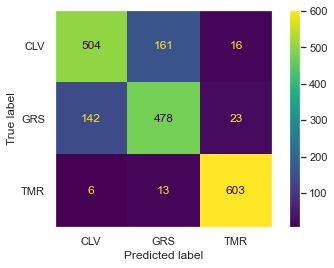


Classification report:
                precision    recall  f1-score   support

         CLV       0.77      0.74      0.76       681
         GRS       0.73      0.74      0.74       643
         TMR       0.94      0.97      0.95       622

    accuracy                           0.81      1946
   macro avg       0.82      0.82      0.82      1946
weighted avg       0.81      0.81      0.81      1946

X_test
Accuracy: 0.8050847457627118


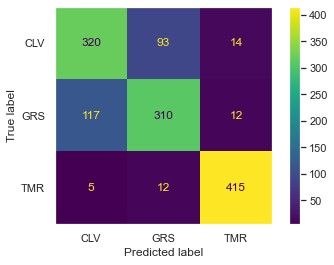


Classification report:
                precision    recall  f1-score   support

         CLV       0.72      0.75      0.74       427
         GRS       0.75      0.71      0.73       439
         TMR       0.94      0.96      0.95       432

    accuracy                           0.81      1298
   macro avg       0.80      0.81      0.80      1298
weighted avg       0.80      0.81      0.80      1298

['GRS' 'CLV' 'GRS' ... 'GRS' 'CLV' 'GRS']
  Predicted      col1      col2      col3      col4      col5      col6  \
0       GRS  1.317418  1.299994  1.284558  1.270085  1.256384  1.243233   
1       CLV  1.316640  1.299685  1.284699  1.270432  1.256800  1.243672   
2       GRS  1.209746  1.196516  1.184740  1.174105  1.164847  1.156824   
3       GRS  1.336356  1.318198  1.301790  1.286056  1.271100  1.256870   
4       CLV  1.332259  1.313666  1.297593  1.282746  1.268823  1.255356   

       col7      col8      col9  ...   col1051   col1052   col1053   col1054  \
0  1.230456  1.21782

In [292]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

#algos_df = pd.DataFrame({"window_idx":[], "acc": []})

#for idx in range(1,len(ridge_windows)+1):
#take the best window size and idx of windows to use
subset_index = evalWindows(ridge_windows, idx = 10)

X_train_auto_windows = X_train[subset_index]
X_test_auto_windows = X_test[subset_index]

clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
        #('feature_selection', SelectKBest(k = 50)),    
        ('classification', LinearDiscriminantAnalysis())
        ])

clf.fit(X_train_auto_windows, y_train)
print("X_train")
y_pred = clf.predict(X_train_auto_windows)
predict_eval(clf, y_train, y_pred)
printMetrics(y_train, y_pred)

print("X_test")
y_pred = clf.predict(X_test_auto_windows)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)
#    algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
#print(algos_df.sort_values('acc', ascending=False))

X_train_full_auto_windows = X[subset_index]
X_test_full_auto_windows = test_df[features][subset_index]

clf.fit(X_train_full_auto_windows, y)
y_pred_test = clf.predict(X_test_full_auto_windows)
#print(X_test_full_auto_windows)
print(y_pred_test)

test_df_pred = pd.concat([pd.DataFrame(y_pred_test, columns=['Predicted'], index=X_test_full_auto_windows.index), X_test_full_auto_windows], axis=1)
print(test_df_pred.head())


In [293]:
# Predicted class on test set
print("Predictions on the unlabeled test data: \n", y_pred_test)

test_df_pred.to_csv('18042021-diet-test-predictions-wsize90-idx10-selectfrommodel-LDA.csv', index=False)



Predictions on the unlabeled test data: 
 ['GRS' 'CLV' 'GRS' ... 'GRS' 'CLV' 'GRS']


In [294]:
y_pred_test.T

array(['GRS', 'CLV', 'GRS', ..., 'GRS', 'CLV', 'GRS'], dtype='<U3')

In [297]:
import collections, numpy
collections.Counter(y_pred_test)

Counter({'GRS': 364, 'CLV': 361, 'TMR': 352})

In [298]:
ridge_windows

[('90:180', 0.6595635430038511),
 ('0:90', 0.6410783055198974),
 ('450:540', 0.593581514762516),
 ('180:270', 0.47933247753530167),
 ('270:360', 0.4593068035943517),
 ('360:450', 0.43465982028241335),
 ('900:990', 0.38279845956354297),
 ('720:810', 0.3779204107830552),
 ('990:1060', 0.37252888318356864),
 ('810:900', 0.37098844672657255),
 ('630:720', 0.36046213093709883),
 ('540:630', 0.3578947368421053)]